# **03 - EDA Visualization**

# **Step 3a - Distribution Review**

# **Geochem Assays**


### Create Histograms



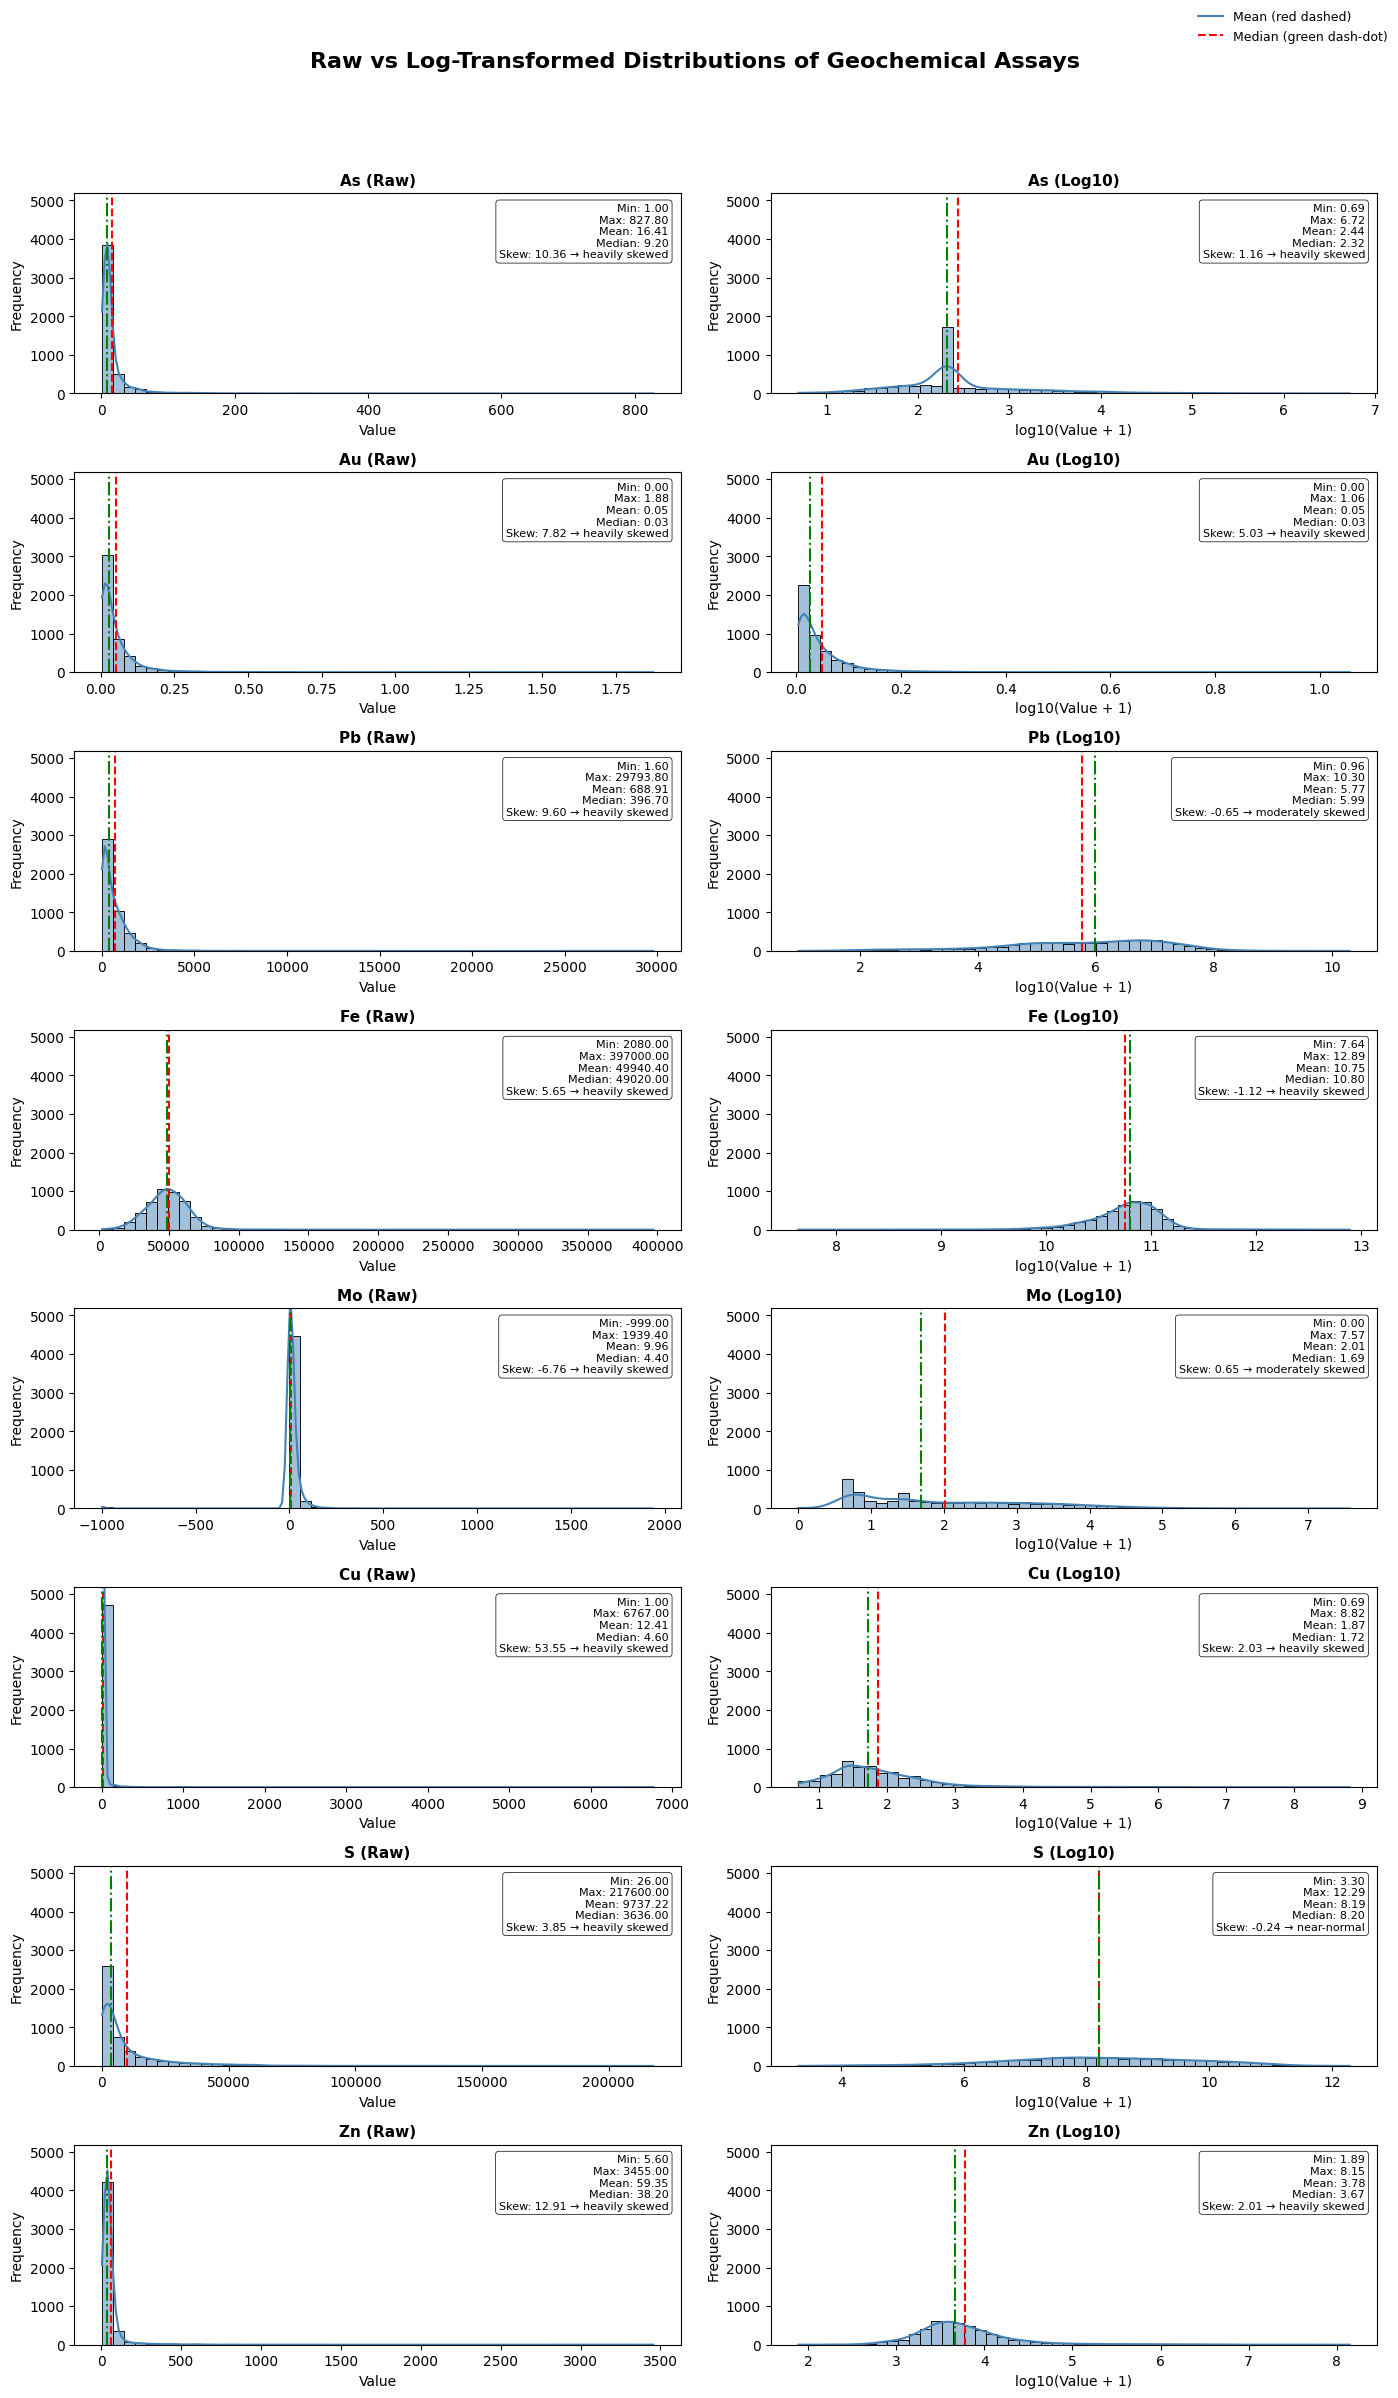

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
import warnings

def interpret_skew(skew_val):
    if np.isnan(skew_val):
        return "not computed"
    elif abs(skew_val) < 0.5:
        return "near-normal"
    elif abs(skew_val) < 1:
        return "moderately skewed"
    else:
        return "heavily skewed"

def safe_fmt(val):
    """Format numbers safely with 2 decimals or return NaN as string."""
    return f"{val:.2f}" if pd.notnull(val) else "NaN"

def plot_raw_vs_log(df, assays_clean, bins=50):
    # --- Determine a common y-limit (max frequency across all assays) ---
    global_ymax = 0
    for col in assays_clean:
        counts, _ = np.histogram(df[col].dropna(), bins=bins)
        if len(counts) > 0:
            global_ymax = max(global_ymax, counts.max())
        counts, _ = np.histogram(np.log1p(df[col].dropna().clip(lower=0)), bins=bins)
        if len(counts) > 0:
            global_ymax = max(global_ymax, counts.max())

    fig, axes = plt.subplots(len(assays_clean), 2, figsize=(14, 3*len(assays_clean)))
    fig.suptitle("Raw vs Log-Transformed Distributions of Geochemical Assays",
                 fontsize=16, weight="bold")

    for i, col in enumerate(assays_clean):
        assay = col.replace("_clean","")
        data_raw = df[col].dropna()
        data_log = np.log1p(data_raw.clip(lower=0))

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            raw_skew = skew(data_raw, nan_policy="omit")
            log_skew = skew(data_log, nan_policy="omit")

        # --- Raw ---
        ax = axes[i,0]
        sns.histplot(data_raw, bins=bins, kde=True, ax=ax, color="steelblue")
        if len(data_raw) > 0:
            ax.axvline(data_raw.mean(), color="red", linestyle="--")
            ax.axvline(data_raw.median(), color="green", linestyle="-.")

        ax.set_title(f"{assay} (Raw)", fontsize=11, weight="bold")
        ax.set_xlabel("Value")
        ax.set_ylabel("Frequency")
        ax.set_ylim(0, global_ymax * 1.1)  # standard y-axis

        stats_text = (
            f"Min: {safe_fmt(data_raw.min())}\n"
            f"Max: {safe_fmt(data_raw.max())}\n"
            f"Mean: {safe_fmt(data_raw.mean())}\n"
            f"Median: {safe_fmt(data_raw.median())}\n"
            f"Skew: {safe_fmt(raw_skew)} → {interpret_skew(raw_skew)}"
        )
        ax.text(0.98, 0.95, stats_text, transform=ax.transAxes,
                ha="right", va="top", fontsize=8,
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5))

        # --- Log ---
        ax = axes[i,1]
        sns.histplot(data_log, bins=bins, kde=True, ax=ax, color="steelblue")
        if len(data_log) > 0:
            ax.axvline(data_log.mean(), color="red", linestyle="--")
            ax.axvline(data_log.median(), color="green", linestyle="-.")

        ax.set_title(f"{assay} (Log10)", fontsize=11, weight="bold")
        ax.set_xlabel("log10(Value + 1)")
        ax.set_ylabel("Frequency")
        ax.set_ylim(0, global_ymax * 1.1)

        stats_text = (
            f"Min: {safe_fmt(data_log.min())}\n"
            f"Max: {safe_fmt(data_log.max())}\n"
            f"Mean: {safe_fmt(data_log.mean())}\n"
            f"Median: {safe_fmt(data_log.median())}\n"
            f"Skew: {safe_fmt(log_skew)} → {interpret_skew(log_skew)}"
        )
        ax.text(0.98, 0.95, stats_text, transform=ax.transAxes,
                ha="right", va="top", fontsize=8,
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5))

    # Shared legend
    fig.legend(["Mean (red dashed)", "Median (green dash-dot)"],
               loc="upper right", fontsize=9, frameon=False)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# --- Run ---
assays_clean = [f"{a}_clean" for a in ['As','Au','Pb','Fe','Mo','Cu','S','Zn']]
plot_raw_vs_log(df_qc, assays_clean, bins=50)







#### Observations

- **Raw space**: All assays are heavily skewed, dominated by low values with long tails.  
- **Log space**: Skewness is reduced for most assays (Pb, Fe, S, Zn in particular).  
- **Best practice**: Use **log-transformed values** for ML modeling

## Create Violin Plots

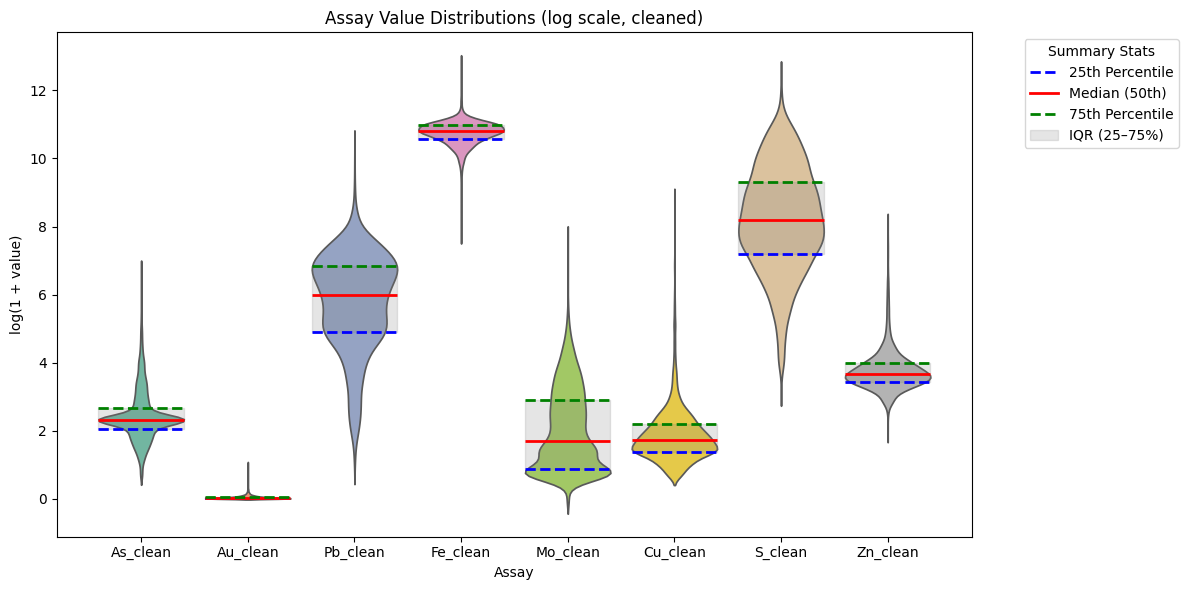

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assay list
assays = ['As','Au','Pb','Fe','Mo','Cu','S','Zn']

# ✅ Safe log transform: clip negatives to 0 before log1p
df_log = df_qc[[f"{a}_clean" for a in assays]].clip(lower=0).apply(lambda x: np.log1p(x))

plt.figure(figsize=(12,6))
ax = sns.violinplot(data=df_log, inner=None, palette="Set2")  # no default quartile lines

# Define quartile line colors
quartile_colors = {
    "25th Percentile": "blue",
    "Median (50th)": "red",
    "75th Percentile": "green"
}

# Loop assays and add quartiles + IQR shading
for i, col in enumerate(df_log.columns):
    data = df_log[col].dropna()
    if len(data) == 0:  # skip empty columns
        continue

    q25 = np.percentile(data, 25)
    q50 = np.percentile(data, 50)
    q75 = np.percentile(data, 75)

    # Shade IQR region
    ax.fill_between([i-0.4, i+0.4], q25, q75, color="gray", alpha=0.2)

    # Add quartile lines
    ax.hlines(q25, i-0.4, i+0.4, color=quartile_colors["25th Percentile"], linestyle="--", lw=2)
    ax.hlines(q50, i-0.4, i+0.4, color=quartile_colors["Median (50th)"], linestyle="-", lw=2)
    ax.hlines(q75, i-0.4, i+0.4, color=quartile_colors["75th Percentile"], linestyle="--", lw=2)

# Add legend
handles = [
    plt.Line2D([0],[0], color=c, linestyle="--" if "Percentile" in k and "Median" not in k else "-", lw=2, label=k)
    for k,c in quartile_colors.items()
]
handles.append(plt.Rectangle((0,0),1,1, color="gray", alpha=0.2, label="IQR (25–75%)"))

ax.legend(handles=handles, title="Summary Stats", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("Assay Value Distributions (log scale, cleaned)")
plt.ylabel("log(1 + value)")
plt.xlabel("Assay")
plt.tight_layout()
plt.show()







### Observations

- **Au (Gold):** Values are extremely compressed near zero. Even after log transform, most measurements sit at the lower bound. This reflects strong detection limit effects and truncation. Au is unlikely to be a reliable continuous predictor but may still contribute as a presence/absence signal.
- **Fe (Iron):** Very tight and compact distribution. Acts as a stable background signal, useful for baseline discrimination of rock types when combined with other assays.
- **S (Sulfur):** Wide, multimodal distribution. Indicates multiple underlying geological processes (e.g., sulfide-rich vs barren environments). Highly informative for classification.
- **Cu, Mo, Pb, Zn:** Broad violins with long tails, showing strong variability and clear anomaly separation. These elements are likely the most discriminative features for rock classification.
- **As (Arsenic):** Although spread is visible, the assay suffers from ~31.5% missing values and should be excluded or treated with extreme caution in downstream modeling.

### Key Takeaways
- **Stable background predictors:** Fe and S  
- **High variability / discriminative predictors:** Pb, Cu, Mo, Zn  
- **Secondary / unreliable predictors:** Au (detection-limited), As (missingness)

# **Rock Classes**

## Create Histogram

Counts:
 Class
A    2861
B    1143
?     767
Name: count, dtype: int64

Percentages:
 Class
A    59.97
B    23.96
?    16.08
Name: proportion, dtype: float64


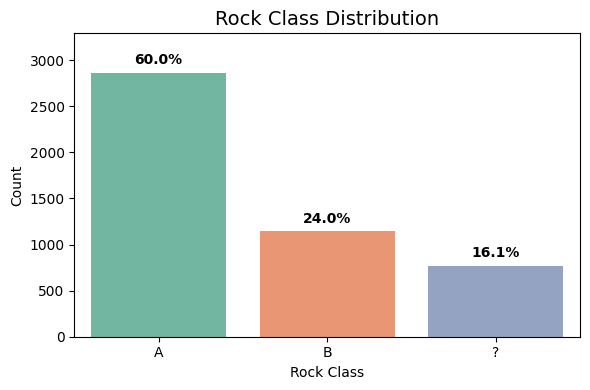

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use cleaned dataset
class_counts = df_qc['Class'].value_counts()
class_pct = df_qc['Class'].value_counts(normalize=True) * 100

print("Counts:\n", class_counts)
print("\nPercentages:\n", class_pct.round(2))

# Plot with annotations
plt.figure(figsize=(6,4))
ax = sns.countplot(x="Class", hue="Class", data=df_qc, palette="Set2", legend=False)

# Add percentage labels on top of bars
for p in ax.patches:
    height = p.get_height()
    class_label = p.get_x() + p.get_width() / 2
    percentage = height / len(df_qc) * 100
    ax.text(class_label, height + (0.02 * ax.get_ylim()[1]), f"{percentage:.1f}%",
            ha="center", va="bottom", fontsize=10, weight="bold")

# Expand y-limit so labels don’t overlap border
ax.set_ylim(0, max(class_counts) * 1.15)

plt.title("Rock Class Distribution", fontsize=14)
plt.xlabel("Rock Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()





### Observations

The dataset is **imbalanced**, with **Class A comprising ~60% of the samples**.  
If left untreated, ML models will tend to **over-predict Class A**, leading to **misleadingly high accuracy**.  

To ensure fair classification, **balancing strategies** such as **Class weights** in model training or  **Resampling techniques** might be needed.



# **Step 3b - Explore Relationships Between Variables**

## Create Heatmap of Variable Relationships

In [39]:
from google.colab import files
uploaded = files.upload()

# Replace with the uploaded file name if different
df_qc = pd.read_csv("cleaned_data.csv")

print("✅ Cleaned dataset loaded from upload")
print("Shape:", df_qc.shape)
print("Columns:", df_qc.columns[:10].tolist())



Saving cleaned_data.csv to cleaned_data (2).csv
✅ Cleaned dataset loaded from upload
Shape: (4771, 45)
Columns: ['Unique_ID', 'holeid', 'from', 'to', 'As', 'Au', 'Pb', 'Fe', 'Mo', 'Cu']


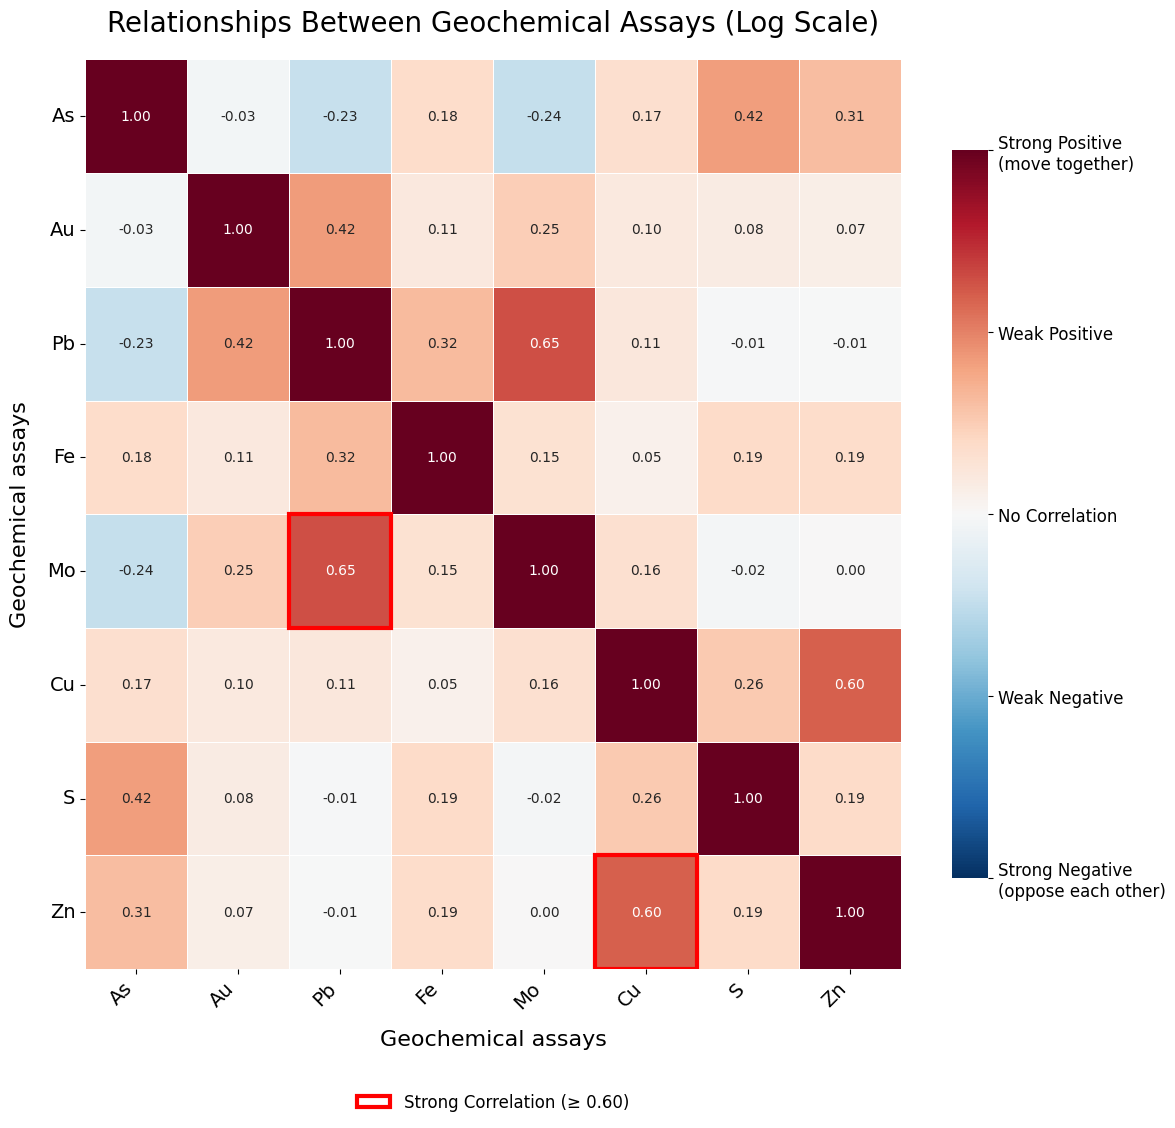

≥ 0.60 correlations: Mo-Pb: 0.65, Zn-Cu: 0.60


In [40]:
# --- Imports ---
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches

# --- Load cleaned dataset ---
df_qc = pd.read_csv("cleaned_data.csv")

# --- Assays of interest ---
assays = ["As", "Au", "Pb", "Fe", "Mo", "Cu", "S", "Zn"]
assays_clean = [f"{a}_clean" for a in assays if f"{a}_clean" in df_qc.columns]

# --- Log10 transform (+1 to avoid log(0)) ---
df_log = np.log10(df_qc[assays_clean].clip(lower=0) + 1)

# --- Correlation matrix ---
corr_raw = df_log.corr()  # keep raw for calculations
corr_matrix = corr_raw.copy()
corr_matrix.index  = [c.replace("_clean","") for c in corr_matrix.index]
corr_matrix.columns = [c.replace("_clean","") for c in corr_matrix.columns]

# --- Plot heatmap ---
plt.figure(figsize=(12, 12))
ax = sns.heatmap(
    corr_matrix,
    annot=True, fmt=".2f",
    cmap="RdBu_r", vmin=-1, vmax=1,
    linewidths=0.5, cbar_kws={"shrink": 0.8}
)

plt.title("Relationships Between Geochemical Assays (Log Scale)", fontsize=20, pad=20)
plt.xlabel("Geochemical assays", fontsize=16, labelpad=12)
plt.ylabel("Geochemical assays", fontsize=16, labelpad=12)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=45, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14, rotation=0)

# Colorbar labels
cb = ax.collections[0].colorbar
cb.set_ticks([-1, -0.5, 0, 0.5, 1])
cb.set_ticklabels([
    "Strong Negative\n(oppose each other)",
    "Weak Negative",
    "No Correlation",
    "Weak Positive",
    "Strong Positive\n(move together)"
])
cb.ax.tick_params(labelsize=12)

# --- Highlight strong correlations (≥ 0.60 by what’s displayed) ---
threshold = 0.60
n = len(corr_matrix)
for i in range(n):
    for j in range(n):
        if i > j:
            # compare using the *rounded* value so it matches the annotation
            val = round(corr_raw.iloc[i, j], 2)
            if val >= threshold:
                ax.add_patch(patches.Rectangle(
                    (j, i), 1, 1, fill=False, edgecolor="red", linewidth=3
                ))

# Legend
legend_patch = patches.Patch(edgecolor="red", facecolor="none",
                             linewidth=3, label="Strong Correlation (≥ 0.60)")
plt.legend(handles=[legend_patch],
           loc="upper center", bbox_to_anchor=(0.5, -0.12),
           fontsize=12, frameon=False)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

# Optional: print the flagged pairs
pairs = []
for i in range(n):
    for j in range(i):
        v = round(corr_raw.iloc[i, j], 2)
        if v >= threshold:
            pairs.append((corr_matrix.index[i], corr_matrix.columns[j], v))
if pairs:
    print("≥ 0.60 correlations:", ", ".join([f"{a}-{b}: {v:.2f}" for a,b,v in pairs]))





### Observations

- **Two strong positive correlations**:
  - **Pb – Mo (0.65)**
  - **Cu – Zn (0.60)**  
  → These elements tend to occur together, likely reflecting shared geochemical processes.

- **Moderate positive links**:
  - **As – S (~0.42)**
  - **Au – Pb (~0.42)**  
  → Indicate some co-association but not as strong.

- **Most other pairs** show weak or near-zero correlation, meaning assays provide **independent information**.

- **Few weak negatives** (e.g., As with Mo or Pb), but no strong negative correlations.

Overall: Only a couple of strong pairwise links exist, so most elements can be treated as complementary inputs for modeling.


## Create Scatterplot for variable pairs

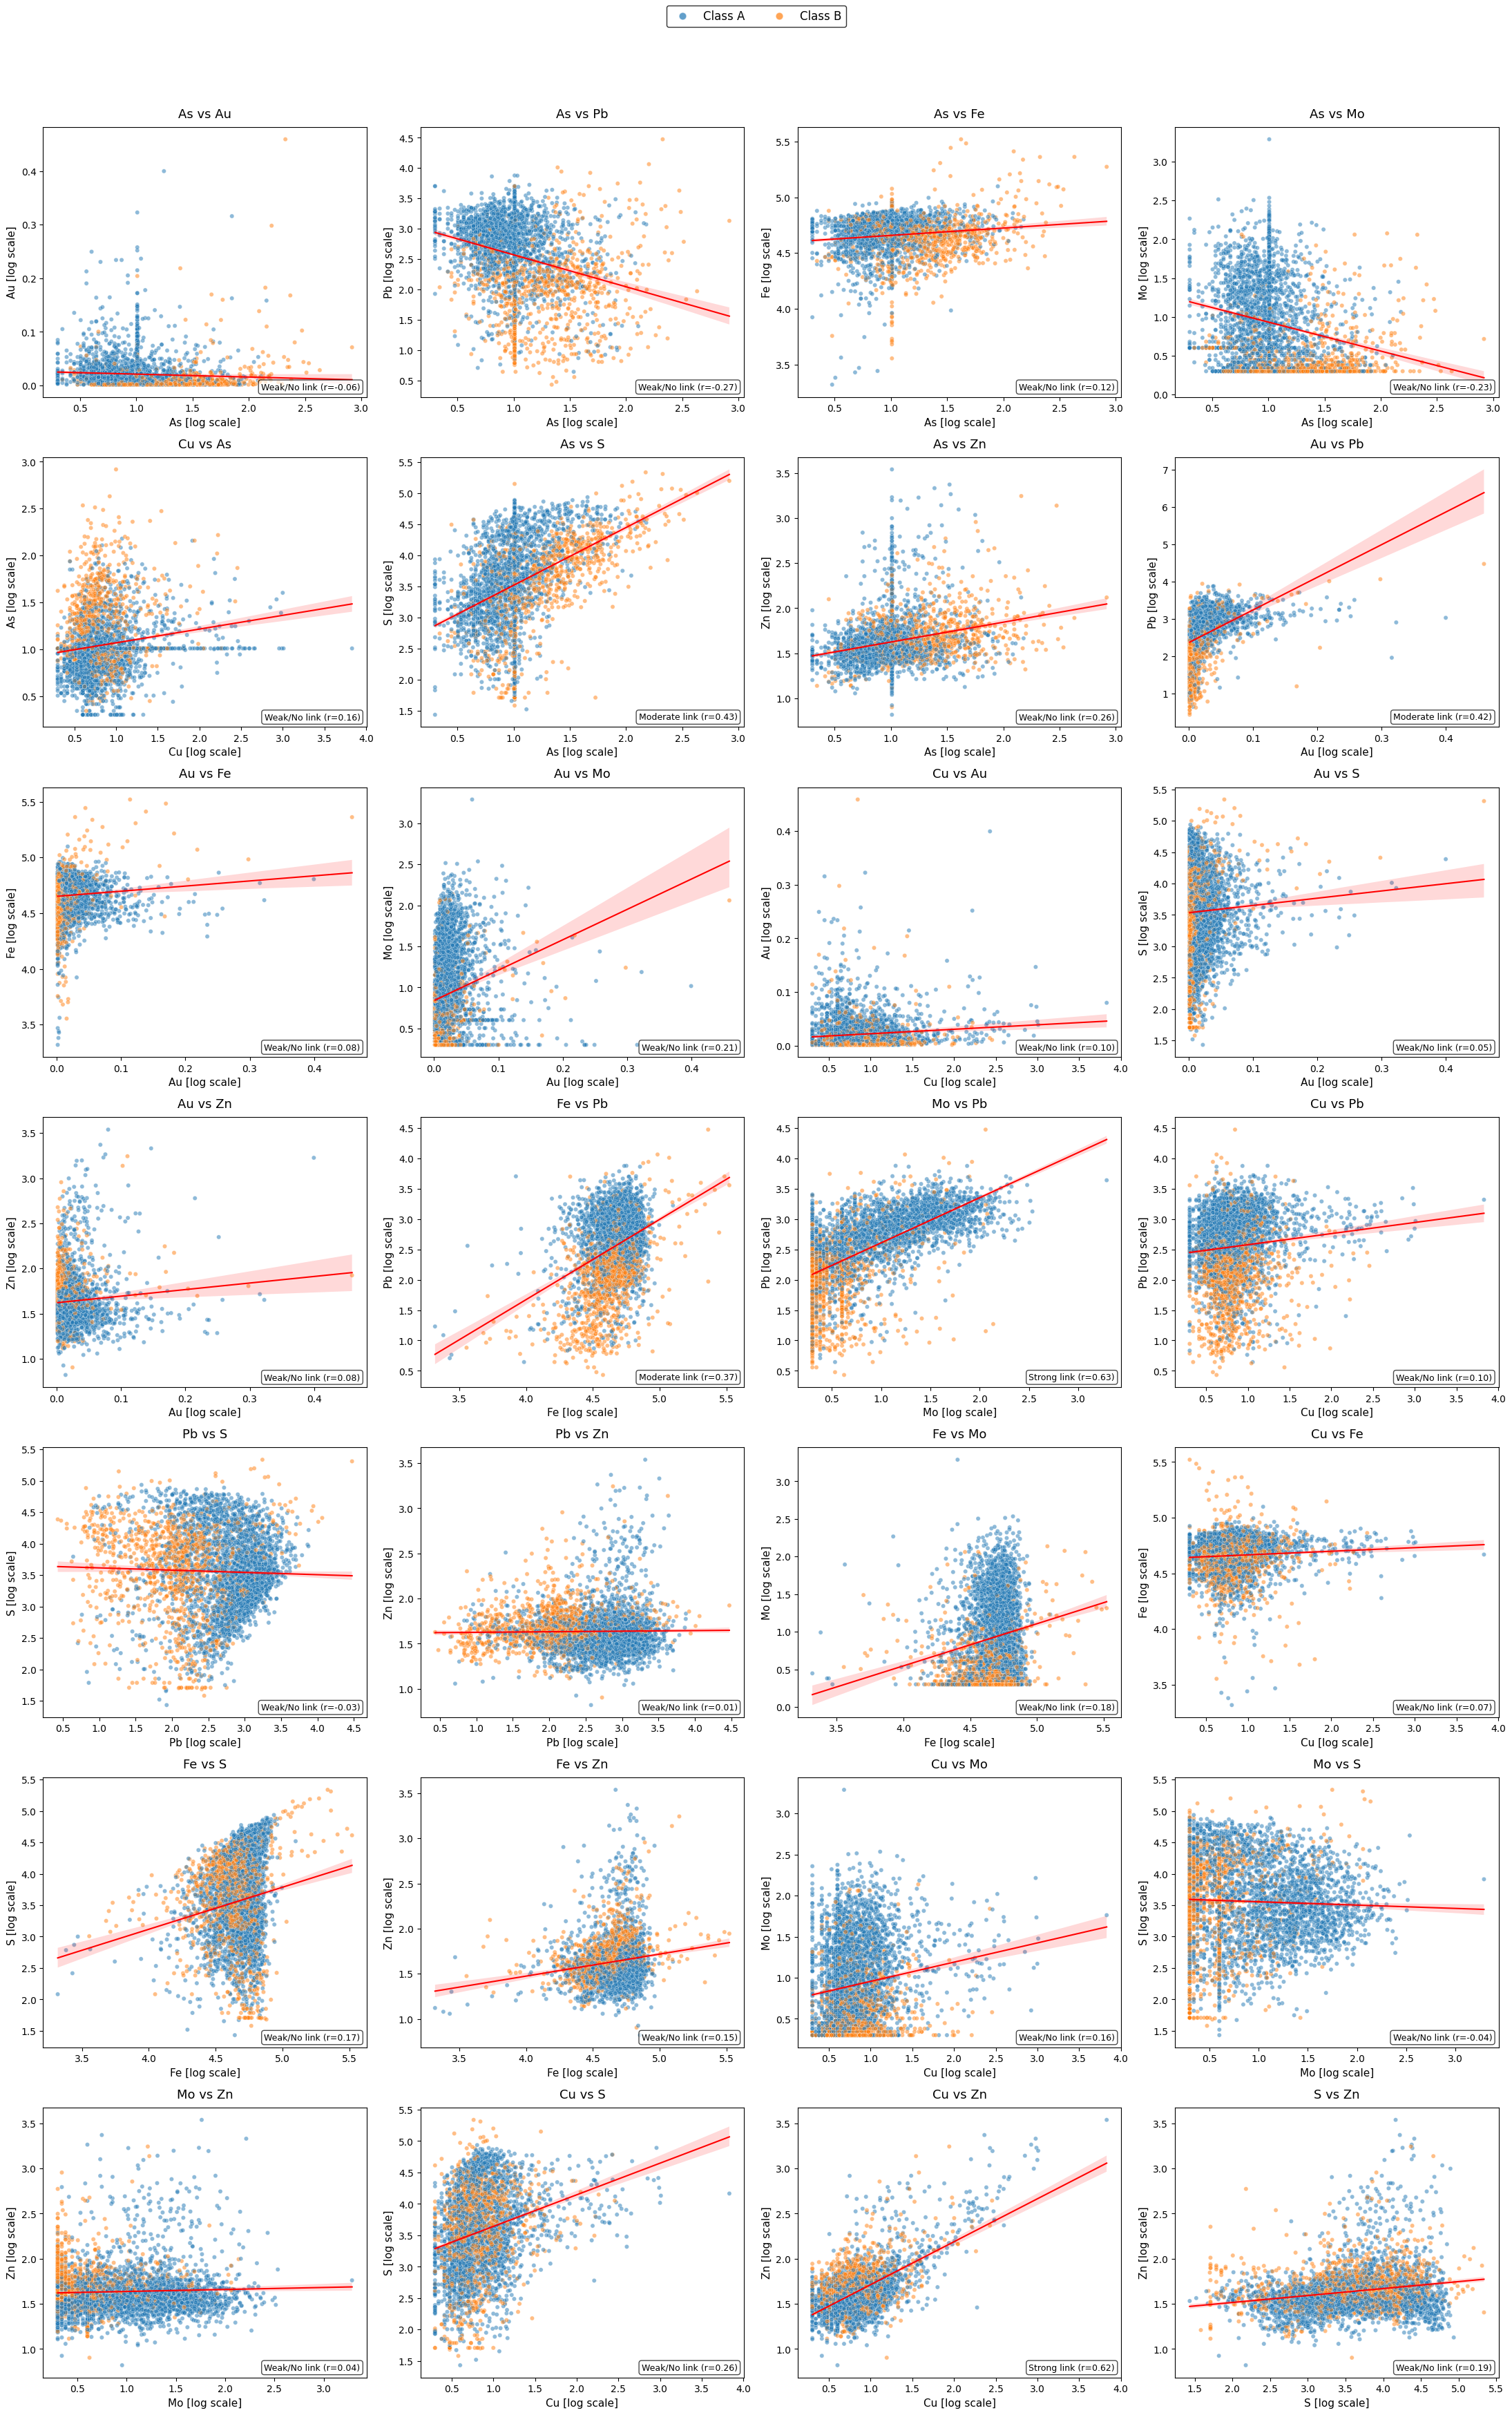

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools
import pandas as pd

# --- Assays and target ---
geochem_elements = ['As_clean', 'Au_clean', 'Pb_clean', 'Fe_clean',
                    'Mo_clean', 'Cu_clean', 'S_clean', 'Zn_clean']

# --- Safe log10 transform ---
with np.errstate(invalid="ignore", divide="ignore"):
    df_log = np.log10(df_qc[geochem_elements].clip(lower=0) + 1)

df_log = df_log.replace([np.inf, -np.inf], np.nan)
df_log['Class'] = df_qc['Class']

# Keep only A and B
df_log = df_log[df_log['Class'].isin(['A', 'B'])]

# --- Generate all unique pairs ---
pairs = list(itertools.combinations(geochem_elements, 2))

# Reorder so Cu is always x-axis if present
ordered_pairs = []
for x, y in pairs:
    if "Cu_clean" in (x, y):
        if x == "Cu_clean":
            ordered_pairs.append((x, y))
        else:
            ordered_pairs.append((y, x))  # Cu first
    else:
        ordered_pairs.append(tuple(sorted((x, y))))
ordered_pairs = list(dict.fromkeys(ordered_pairs))

# --- Plot grid ---
ncols = 4
nrows = int(np.ceil(len(ordered_pairs) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(22, nrows * 5))
axes = axes.flatten()

# Custom palette with class labels
palette = {"A": "#1f77b4", "B": "#ff7f0e"}
label_map = {"A": "Class A", "B": "Class B"}

for ax, (x, y) in zip(axes, ordered_pairs):
    # Drop NaNs
    valid = df_log[[x, y]].dropna()
    if valid.shape[0] > 1:
        r = valid.corr().iloc[0, 1]
    else:
        r = np.nan

    # Scatter colored by class
    sns.scatterplot(
        data=df_log,
        x=x, y=y,
        hue="Class",
        palette=palette,
        alpha=0.5,
        s=20,
        ax=ax,
        legend=False  # no legends in subplots
    )

    # Regression line
    sns.regplot(
        x=df_log[x], y=df_log[y],
        scatter=False,
        line_kws={"color": "red", "lw": 1.5},
        ax=ax
    )

    # Titles and labels
    ax.set_title(f"{x.replace('_clean','')} vs {y.replace('_clean','')}", fontsize=13, pad=10)
    ax.set_xlabel(f"{x.replace('_clean','')} [log scale]", fontsize=11)
    ax.set_ylabel(f"{y.replace('_clean','')} [log scale]", fontsize=11)

    # Correlation annotation
    if pd.notna(r):
        if abs(r) >= 0.6:
            comment = f"Strong link (r={r:.2f})"
        elif abs(r) >= 0.3:
            comment = f"Moderate link (r={r:.2f})"
        else:
            comment = f"Weak/No link (r={r:.2f})"
    else:
        comment = "Not enough data"

    ax.text(
        0.98, 0.02,
        comment,
        transform=ax.transAxes,
        fontsize=9,
        va="bottom", ha="right",
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
    )

# Hide unused axes
for i in range(len(ordered_pairs), len(axes)):
    fig.delaxes(axes[i])

# --- Global legend ---
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Class A',
           markerfacecolor=palette['A'], markersize=8, alpha=0.7),
    Line2D([0], [0], marker='o', color='w', label='Class B',
           markerfacecolor=palette['B'], markersize=8, alpha=0.7)
]
fig.legend(handles=legend_elements, loc="upper center", ncol=2,
           frameon=True, facecolor="white", edgecolor="black", fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for legend
plt.show()





### Observations

- Most element pairs show **weak or no clear linear relationship**, meaning they vary independently.  
- Two pairs stand out with **strong positive associations**: **Mo–Pb (r ≈ 0.65)** and **Cu–Zn (r ≈ 0.60)**, suggesting linked geochemical processes.  
- While Class A and Class B points largely **overlap** in 2D plots, subtle shifts are visible in some pairs.  
- This indicates that **no single element pair can fully separate the classes**; instead, a **multivariate model** will be needed to capture class differences.  


## PCA (Principal Component Analysis)

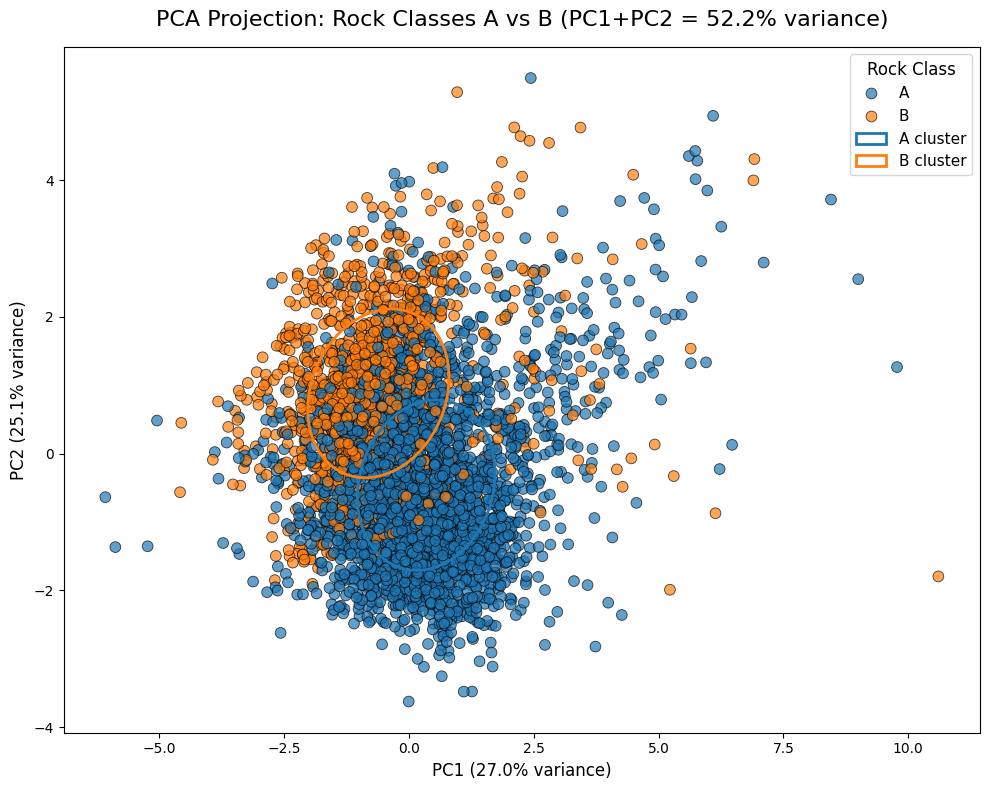

Explained Variance by Principal Components:
    PC  Variance (%)
0  PC1         27.04
1  PC2         25.14


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Ellipse

# --- Assays to include ---
assays = ["As_clean", "Au_clean", "Pb_clean", "Fe_clean",
          "Mo_clean", "Cu_clean", "S_clean", "Zn_clean"]

# --- 1. Ensure numeric ---
df_num = df_qc[assays].apply(pd.to_numeric, errors="coerce")

# --- 2. Replace negatives with 0 (not valid for assays) ---
df_num[df_num < 0] = 0

# --- 3. Fill remaining NaNs with median ---
df_num = df_num.fillna(df_num.median())

# --- 4. Log-transform (+1 for stability) ---
df_log = np.log10(df_num + 1)

# --- 5. Standardize ---
X_scaled = StandardScaler().fit_transform(df_log)

# --- 6. PCA (2 components) ---
pca = PCA(n_components=2)
pcs = pca.fit_transform(X_scaled)

# --- 7. PCA dataframe ---
df_pca = pd.DataFrame(pcs, columns=["PC1", "PC2"])
df_pca["Class"] = df_qc["Class"]

# --- 8. Keep only labeled classes (A, B) ---
df_pca = df_pca[df_pca["Class"].isin(["A", "B"])]

# --- 9. Palette (A=blue, B=orange) ---
palette = {"A": "#1f77b4", "B": "#ff7f0e"}

# --- 10. Plot points ---
plt.figure(figsize=(10, 8))
ax = sns.scatterplot(
    data=df_pca,
    x="PC1", y="PC2",
    hue="Class",
    palette=palette,
    alpha=0.7,
    s=60,
    edgecolor="k"
)

# --- 11. Function to draw ellipse for each class ---
def plot_ellipse(x, y, ax, edgecolor, label):
    cov = np.cov(x, y)
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]

    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    width, height = 2 * np.sqrt(vals)  # 1 std dev ellipse

    ell = Ellipse((np.mean(x), np.mean(y)),
                  width, height,
                  angle=theta,
                  edgecolor=edgecolor,
                  facecolor="none",
                  linewidth=2,
                  label=f"{label} cluster")
    ax.add_patch(ell)

# --- 12. Add ellipses for A and B ---
for cls, color in palette.items():
    subset = df_pca[df_pca["Class"] == cls]
    plot_ellipse(subset["PC1"], subset["PC2"], ax, color, cls)

# Titles and labels
plt.title(
    f"PCA Projection: Rock Classes A vs B (PC1+PC2 = {pca.explained_variance_ratio_[:2].sum()*100:.1f}% variance)",
    fontsize=16, pad=15
)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)", fontsize=12)
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)", fontsize=12)

plt.legend(title="Rock Class", fontsize=11, title_fontsize=12, loc="best", frameon=True)
plt.tight_layout()
plt.show()

# --- 13. Variance explained table ---
explained = pd.DataFrame({
    "PC": [f"PC{i+1}" for i in range(len(pca.explained_variance_ratio_))],
    "Variance (%)": np.round(pca.explained_variance_ratio_ * 100, 2)
})
print("Explained Variance by Principal Components:")
print(explained.head(5))







### Observations
- The PCA plot shows that **Class A and Class B samples are partly separated**, meaning the geochemical assays contain useful information for distinguishing them.  
- However, there is still some **overlap**, suggesting the separation is not perfect and the problem is moderately challenging.  
- This means the dataset has predictive potential, but simple models may struggle without balancing and careful evaluation.



# EDA Visualization Summary

- Log scale plots are more appropriate for analysis and detecting meaningful relationships.
- Some elements (like **Copper, Zinc, Lead, and Molybdenum**) carry strong signals and will be useful for prediction.  
- Other elements (like **Gold and Arsenic**) are less reliable due to many missing or limited values.  
- There is a **class imbalance** (most samples are Class A), which could bias results unless corrected.  
- Relationships between elements exist (e.g., Copper–Zinc, Lead–Molybdenum), but no single element explains the classes alone.  

